In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [3]:
# Step 1: Load the Wine dataset
filePath = 'https://raw.githubusercontent.com/kexin516/Wine-Classifier-Comparison/main/'
filename = 'wine.csv'
names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df = pd.read_csv(filePath+filename, names=names, header=None)

In [4]:
# Preview the data
df.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
# Step 2: Prepare features and target
X = df.iloc[:, 1:]  # 13 chemical features
y = df.iloc[:, 0]   # Target class (1, 2, 3)

In [5]:
# Standardize features for better SVC performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Step 3: Define classifiers
svc = SVC(kernel='rbf', C=1.0, probability=True)  # RBF kernel with C=1.0
rf = RandomForestClassifier(max_depth=2, random_state=42)
adb = AdaBoostClassifier(random_state=42)

classifiers = {
    "SVC (RBF Kernel)": svc,
    "Random Forest (depth=2)": rf,
    "AdaBoost": adb
}

In [7]:
# Step 4: Evaluate models using Stratified K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = {}

for name, model in classifiers.items():
    scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='accuracy')
    accuracy_scores[name] = scores
    print(f"{name} Accuracy Scores: {scores}")
    print(f"{name} Mean Accuracy: {scores.mean():.4f}")

SVC (RBF Kernel) Accuracy Scores: [1.         0.88888889 1.         1.         0.94444444 1.
 1.         1.         1.         1.        ]
SVC (RBF Kernel) Mean Accuracy: 0.9833
Random Forest (depth=2) Accuracy Scores: [1.         0.94444444 1.         1.         1.         0.94444444
 1.         0.94444444 1.         1.        ]
Random Forest (depth=2) Mean Accuracy: 0.9833
AdaBoost Accuracy Scores: [1.         0.88888889 0.77777778 0.77777778 0.94444444 0.94444444
 1.         0.77777778 0.94117647 0.94117647]
AdaBoost Mean Accuracy: 0.8993


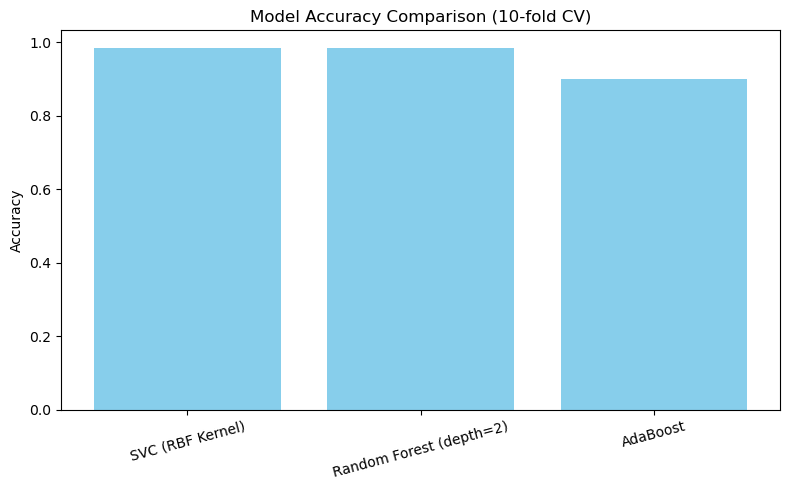

In [8]:
# Step 5: Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(accuracy_scores.keys(), [np.mean(scores) for scores in accuracy_scores.values()], color='skyblue')
plt.title('Model Accuracy Comparison (10-fold CV)')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [9]:
# Both SVC (RBF) and Random Forest (depth=2) provided robust and reliable classification (both achieved a mean accuracy of 98.33%), while AdaBoost may need parameter tuning or more boosting rounds to improve its consistency.

SVC (RBF Kernel) Overall ROC AUC (micro): 1.0000
SVC (RBF Kernel) Overall ROC AUC (macro, via roc_auc_score): 1.0000
SVC (RBF Kernel) Overall ROC AUC (micro): 1.0000
Random Forest (depth=2) Overall ROC AUC (micro): 0.9997
Random Forest (depth=2) Overall ROC AUC (macro, via roc_auc_score): 0.9999
Random Forest (depth=2) Overall ROC AUC (micro): 0.9997
AdaBoost Overall ROC AUC (micro): 0.9987
AdaBoost Overall ROC AUC (macro, via roc_auc_score): 0.9979
AdaBoost Overall ROC AUC (micro): 0.9987


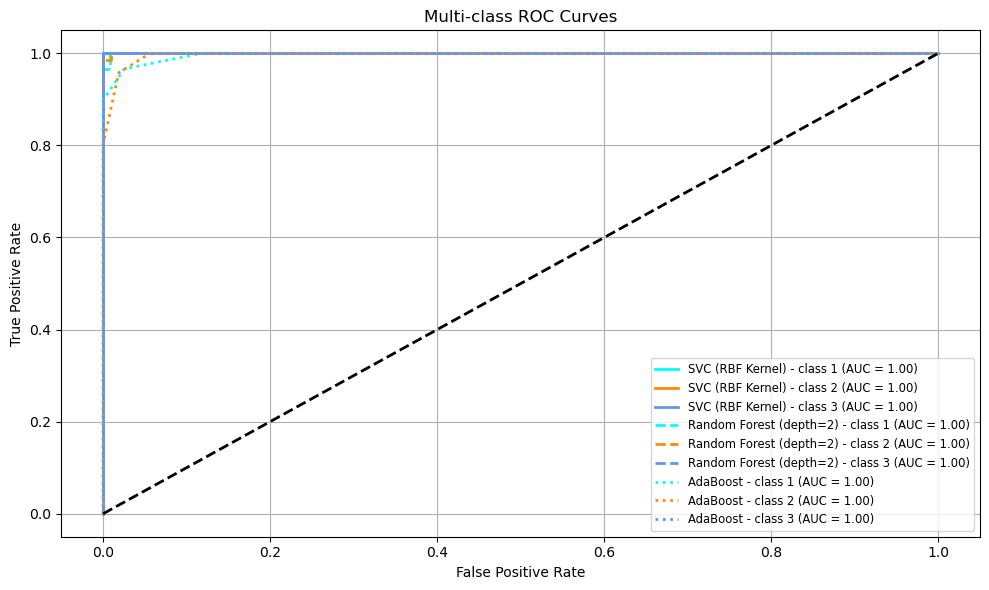

In [10]:
# Step 6: Multi-class ROC Curve and ROC AUC
# Binarize the output for ROC calculation
y_bin = label_binarize(y, classes=[1, 2, 3])
n_classes = y_bin.shape[1]

# Fit each classifier and plot ROC curve
line_styles = cycle(['-', '--', ':'])
plt.figure(figsize=(10, 6))

for (name, clf), ls in zip(classifiers.items(), line_styles):
    clf.fit(X_scaled, y)
    y_score = clf.predict_proba(X_scaled)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute per-class ROC and AUC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Macro-average ROC AUC score using roc_auc_score function
    roc_auc_macro = roc_auc_score(y_bin, y_score, average="macro", multi_class="ovr")
    print(f"{name} Overall ROC AUC (micro): {roc_auc['micro']:.4f}")
    print(f"{name} Overall ROC AUC (macro, via roc_auc_score): {roc_auc_macro:.4f}")

    # Plot all ROC curves for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], linestyle=ls, color=color, lw=2,
                 label=f'{name} - class {i+1} (AUC = {roc_auc[i]:.2f})')
    
    print(f"{name} Overall ROC AUC (micro): {roc_auc['micro']:.4f}")

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal Line
plt.title('Multi-class ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# All three classifiers are highly effective on the Wine dataset.
# SVC performs the best overall.
# Random Forest with just depth=2 is nearly as good.
# AdaBoost also performs very well, though with slightly less consistency across all classes. 